<a href="https://colab.research.google.com/github/crislivera/XploreLanka/blob/DataScience/tfTestLast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [0]:
df = pd.read_csv('Anur.csv', date_parser =True)
df = df[['Date','Temp C']]
df

,Date,Temp C
0,1/1/2009,30
1,2/1/2009,31
2,3/1/2009,31
3,4/1/2009,29
4,5/1/2009,31
...,...,...
4012,27/12/2019,29
4013,28/12/2019,28
4014,29/12/2019,29
4015,30/12/2019,30


In [0]:
trainingData = df[:-365].copy()
trainingData = trainingData.set_index('Date')
trainingData

,Temp C
Date,
1/1/2009,30
2/1/2009,31
3/1/2009,31
4/1/2009,29
5/1/2009,31
...,...
27/12/2018,31
28/12/2018,30
29/12/2018,29


In [0]:
#trainingData = np.asarray(trainingData)

In [0]:
testingData = df[-365:].copy()
testingData = testingData.set_index('Date')
testingData


,Temp C
Date,
1/1/2019,27
2/1/2019,27
3/1/2019,29
4/1/2019,29
5/1/2019,29
...,...
27/12/2019,29
28/12/2019,28
29/12/2019,29


In [0]:
#testingData = np.asarray(testingData)

In [0]:
#scaler = MinMaxScaler()
#actualTrainingData = scaler.fit_transform(actualTrainingData)
#actualTrainingData

scaler=MinMaxScaler()
scaler.fit(trainingData)
trainingData=scaler.transform(trainingData)
testingData=scaler.transform(testingData)

In [0]:
n_input=100
n_features=1

generator=TimeseriesGenerator(trainingData, trainingData, length=n_input, batch_size=32)

In [0]:
x_train = []
y_train = []

In [0]:
for i in range(60, trainingData.shape[0]):
    x_train.append(trainingData[i-60:i])
    y_train.append(trainingData[i, 0])

In [0]:
x_train , y_train =np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

((3592, 60, 1), (3592,))

### LSTM

In [0]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


In [0]:
regressior = Sequential()
regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], 1)))
regressior.add(Dropout(0.2))

regressior.add(LSTM(units=60, activation='relu',return_sequences= True))
regressior.add(Dropout(0.2))

regressior.add(LSTM(units=80, activation='relu',return_sequences= True))
regressior.add(Dropout(0.2))

regressior.add(LSTM(units=120, activation='relu'))
regressior.add(Dropout(0.2))

regressior.add(Dense(units=1))

In [0]:
regressior.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 80)            45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 60, 80)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

In [0]:
regressior.compile(optimizer='adam', loss='mean_squared_error')

In [0]:
regressior.fit(x_train,y_train, epochs=180, batch_size=32)


Epoch 1/180
113/113 [==============================] - 17s 148ms/step - loss: 0.0379
Epoch 2/180
113/113 [==============================] - 17s 154ms/step - loss: 0.0150
Epoch 3/180
113/113 [==============================] - 17s 154ms/step - loss: 0.0145
Epoch 4/180
113/113 [==============================] - 17s 154ms/step - loss: 0.0144
Epoch 5/180
113/113 [==============================] - 17s 155ms/step - loss: 0.0137
Epoch 6/180
113/113 [==============================] - 18s 156ms/step - loss: 0.0136
Epoch 7/180
113/113 [==============================] - 18s 158ms/step - loss: 0.0131
Epoch 8/180
113/113 [==============================] - 18s 156ms/step - loss: 0.0126
Epoch 9/180
113/113 [==============================] - 18s 156ms/step - loss: 0.0124
Epoch 10/180
113/113 [==============================] - 18s 160ms/step - loss: 0.0122
Epoch 11/180
113/113 [==============================] - 18s 158ms/step - loss: 0.0122
Epoch 12/180
113/113 [==============================] - 18s 156

In [0]:
pred_list = []

batch = testingData[-x_train.shape[1]:].reshape((1, x_train.shape[1], 1))

for i in range(x_train.shape[1]):
    pred_list.append(regressior.predict(batch)[0])
    batch = np.append(batch[:,1:,:],[[pred_list[i]]], axis=1)
    


In [0]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=df[-x_train.shape[1]:].index, columns=['Predictions'])

df_test = pd.concat([df, df_predict], axis=1)
df_test.to_csv('pred2.csv', index=False)

In [0]:
df_test.tail(100)

NameError: ignored

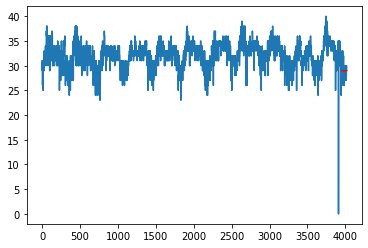

In [0]:
plt.plot(df_test.index, df_test['Temp C'])
plt.plot(df_test.index, df_test['Predictions'], color='r')
plt.show()